# Predict Number of Bikes Rented with Linear Regression

In [21]:
#install.packages("corrplot", repos='http://cran.us.r-project.org')
#install.packages("corrgram", repos='http://cran.us.r-project.org')

In [12]:
library(ggplot2)
library(ggthemes)
library(dplyr)
library(corrplot)
library(corrgram)

In [4]:
#trying to predict the total count of bikes rented during eqach hour covered by the test set
bike <- read.csv('bikeshare.csv')
head(bike)

datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1


## EXPLORATORY DATA ANALYSIS

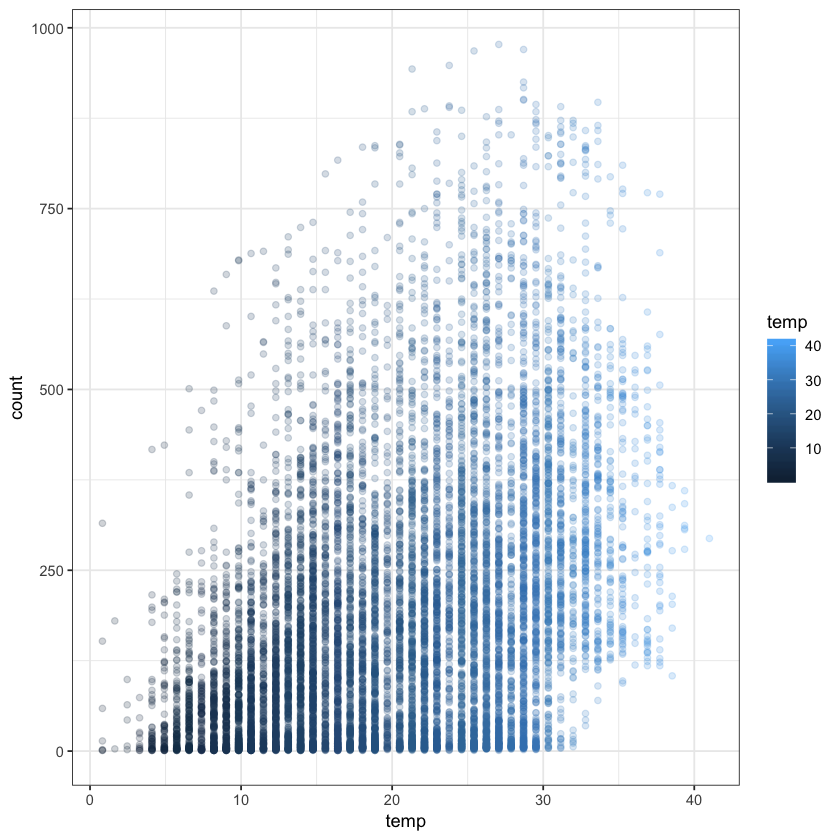

In [5]:
#scatter plot of count vs temp
ggplot(bike, aes(x=temp, y=count)) + geom_point(alpha=0.2, aes(color=temp)) + theme_bw()

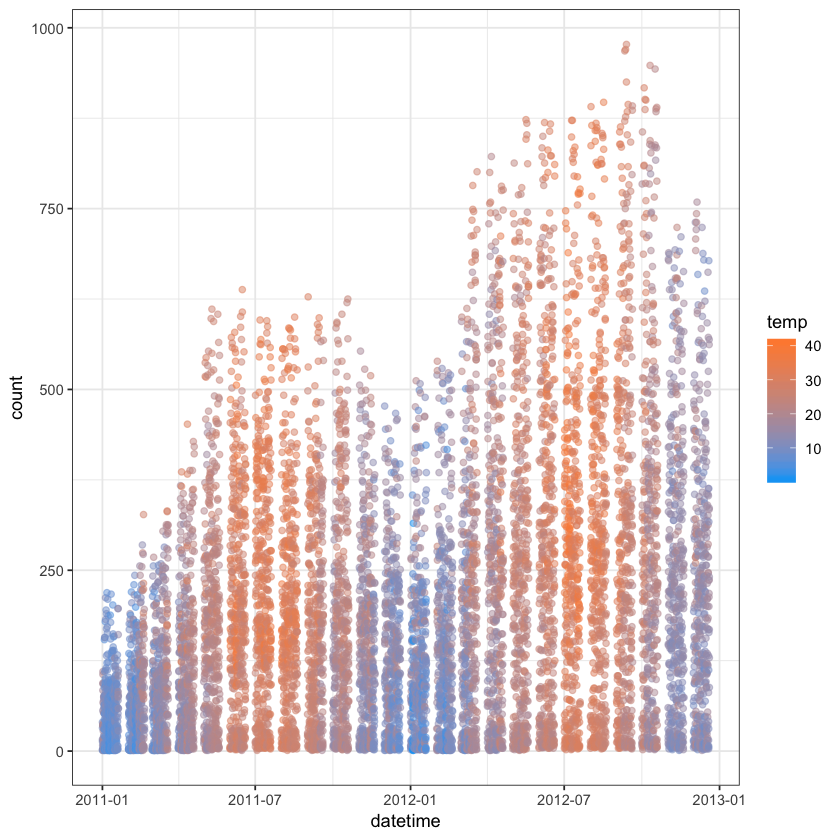

In [6]:
#plot count vs datetime as scatterplot
bike$datetime <- as.POSIXct(bike$datetime)
ggplot(bike, aes(datetime, count)) + geom_point(aes(color=temp), alpha=0.5) + scale_color_continuous(low='#10a5f5', high='#ff8b3d') + theme_bw()

There's serasonality to the data for winter and summer, and the count is increasing overall -- data is non-linear.

In [8]:
#correlation between temp and count
cor(bike[, c('temp', 'count')])

,temp,count
temp,1.0000000,0.3944536
count,0.3944536,1.0000000


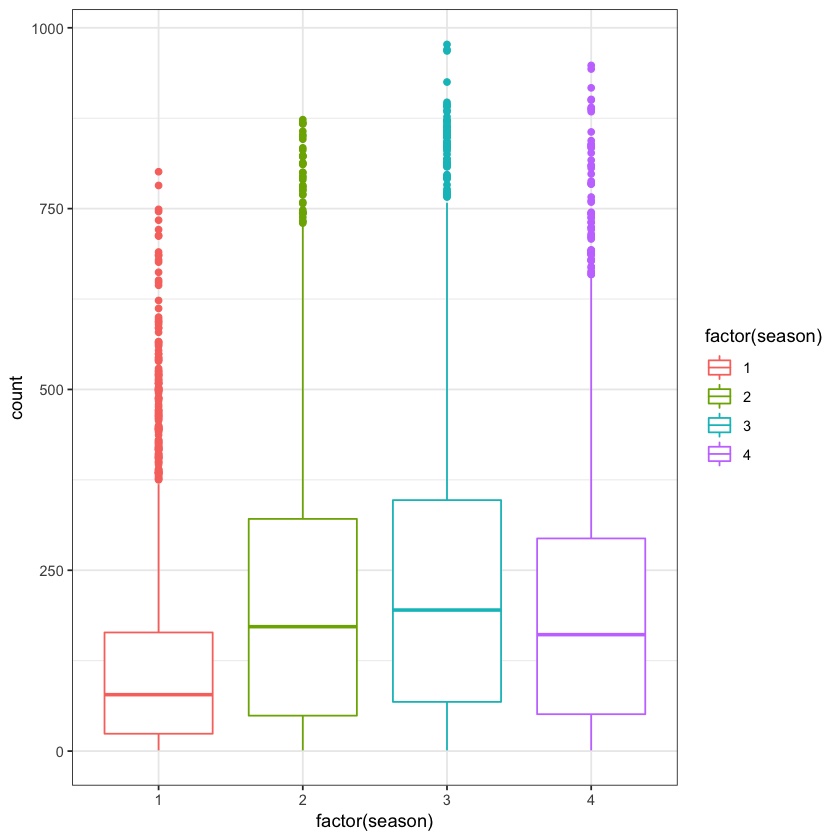

In [13]:
#explore season data: boxlpot
ggplot(bike, aes(factor(season), count)) + geom_boxplot(aes(color=factor(season))) + theme_bw()

There are more rentals in winter than in spring/a line can't capture a non-linear relationship; this is due to growth of rental count, not actual season.


## FEATURE ENGINEERING

In [14]:
#new hour column
bike$hour <- sapply(bike$datetime, function(x){format(x, "%H")})
head(bike)

datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,00
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,01
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,02
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,03
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,04
2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,05


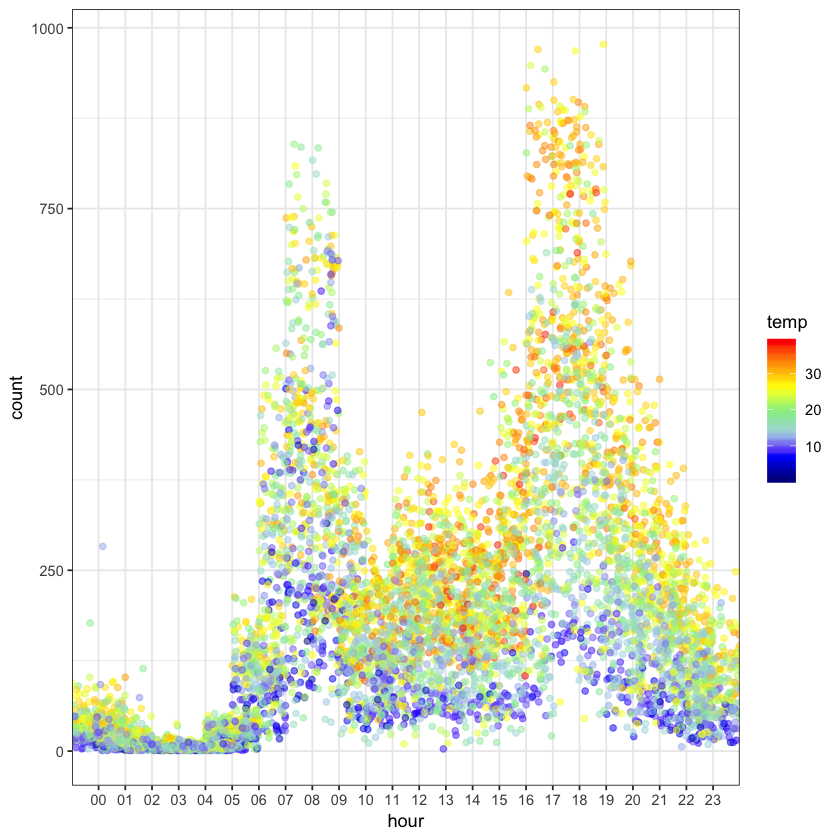

In [15]:
#scatterplot of count vs hour for working days
pl <- ggplot(filter(bike, workingday==1), aes(x=hour, y=count))
pl <- pl + geom_point(position=position_jitter(w=1, h=0), alpha=0.5, aes(color=temp)) + theme_bw() + scale_color_gradientn(colours = c('dark blue', 'blue', 'light blue', 'light green', 'yellow', 'orange', 'red'))
print(pl)

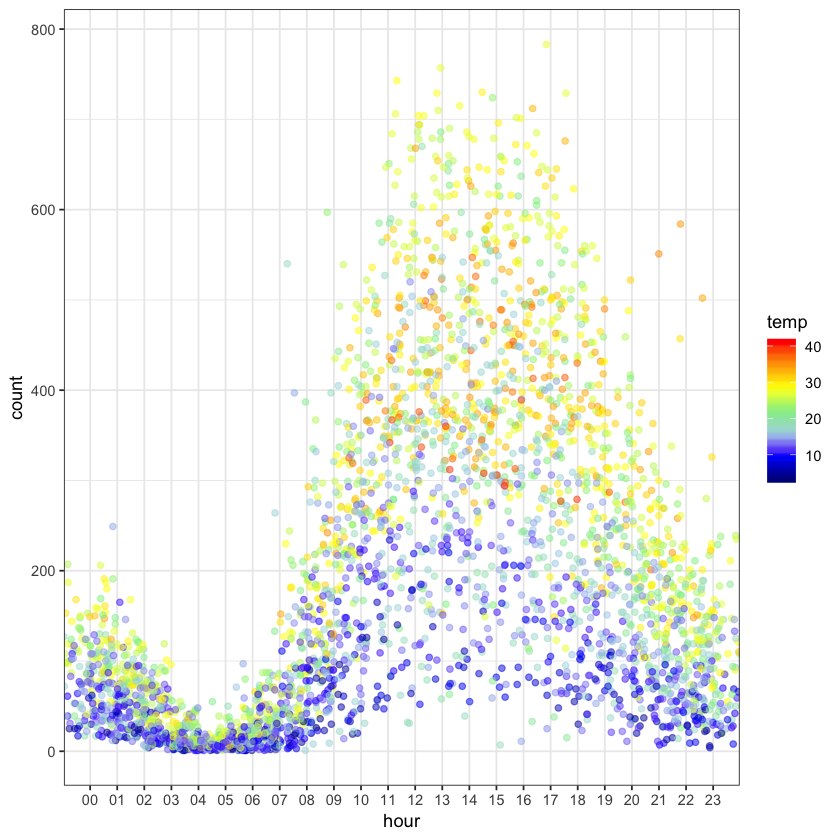

In [16]:
#scatterplot of count vs hour for non working days
pl2 <- ggplot(filter(bike, workingday==0), aes(x=hour, y=count))
pl2 <- pl2 + geom_point(position=position_jitter(w=1, h=0), alpha=0.5, aes(color=temp)) + theme_bw() + scale_color_gradientn(colours = c('dark blue', 'blue', 'light blue', 'light green', 'yellow', 'orange', 'red'))
print(pl2)

# BUILDING THE MODEL

In [17]:
temp_model <- lm(count ~ temp, bike)
summary(temp_model)


Call:
lm(formula = count ~ temp, data = bike)

Residuals:
    Min      1Q  Median      3Q     Max 
-293.32 -112.36  -33.36   78.98  741.44 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   6.0462     4.4394   1.362    0.173    
temp          9.1705     0.2048  44.783   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 166.5 on 10884 degrees of freedom
Multiple R-squared:  0.1556,	Adjusted R-squared:  0.1555 
F-statistic:  2006 on 1 and 10884 DF,  p-value: < 2.2e-16


- Intercept 6.0462: estimated number of rentals when the temperature is 0 degrees celcius
- temp coefficient 9.1705: for every temperature increase of 1 degree celcius, the estimated number of rentals of bikes increases 9.17
- predict to get 235.3087 bike rentals if temperature was 25 degrees celcius

In [18]:
6.0462+9.1705*25 #method 1
temp_test <- data.frame(temp=c(25)) #method 2
predict(temp_model, temp_test)

[1] 235.3087

1 
235.3097

In [19]:
bike$hour <- sapply(bike$hour, as.numeric)

In [20]:
#model to predict count based off of season, holiday, workingday, weather, temp, humidity, windspeed, hour(factor)
model <- lm(count~season+holiday+workingday+weather+temp+humidity+windspeed+hour, bike)
summary(model)


Call:
lm(formula = count ~ season + holiday + workingday + weather + 
    temp + humidity + windspeed + hour, data = bike)

Residuals:
    Min      1Q  Median      3Q     Max 
-324.61  -96.88  -31.01   55.27  688.83 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  46.91369    8.45147   5.551 2.91e-08 ***
season       21.70333    1.35409  16.028  < 2e-16 ***
holiday     -10.29914    8.79069  -1.172    0.241    
workingday   -0.71781    3.14463  -0.228    0.819    
weather      -3.20909    2.49731  -1.285    0.199    
temp          7.01953    0.19135  36.684  < 2e-16 ***
humidity     -2.21174    0.09083 -24.349  < 2e-16 ***
windspeed     0.20271    0.18639   1.088    0.277    
hour          7.61283    0.21688  35.102  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 147.8 on 10877 degrees of freedom
Multiple R-squared:  0.3344,	Adjusted R-squared:  0.3339 
F-statistic:   683 on 8 and 10877 DF,  p-v

Model did not perform well be, the R-squared is low. This data is not good with linear model because 
there's seasonality in this time-series data.
